## Sentence Sentiment based rating prediction - model - 03

In [100]:
import gzip
import pandas as pd
import numpy as np
import goslate
import json
import requests

import nltk
import string
from nltk.stem.porter import *
from nltk.corpus import stopwords
nltk.download("stopwords")
from textblob import TextBlob

from sklearn import linear_model
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Note**: If required, use cd .. or pwd commands based on your folder structure to read the data files.

In [9]:
pwd

'/home/jovyan/git/rating-prediction-google-local'

In [10]:
data_places = []
data_reviews = []
with gzip.open("data/places.clean.json.gz") as f:
    for l in f:
        data_places.append(eval(l))

In [11]:
len(data_places), data_places[:1]

(3114353,
 [{'name': 'Diamond Valley Lake Marina',
   'price': None,
   'address': ['2615 Angler Ave', 'Hemet, CA 92545'],
   'hours': [['Monday', [['6:30 am--4:15 pm']]],
    ['Tuesday', [['6:30 am--4:15 pm']]],
    ['Wednesday', [['6:30 am--4:15 pm']], 1],
    ['Thursday', [['6:30 am--4:15 pm']]],
    ['Friday', [['6:30 am--4:15 pm']]],
    ['Saturday', [['6:30 am--4:15 pm']]],
    ['Sunday', [['6:30 am--4:15 pm']]]],
   'phone': '(951) 926-7201',
   'closed': False,
   'gPlusPlaceId': '104699454385822125632',
   'gps': [33.703804, -117.003209]}])

In [12]:
N = 4000000
data_reviews = []
with gzip.open("data/reviews.clean.json.gz") as f:
    head = [next(f) for x in range(N)]
    for l in head:
        data_reviews.append(eval(l))

In [13]:
data_reviews[:1], len(data_reviews)

([{'rating': 3.0,
   'reviewerName': 'an lam',
   'reviewText': 'Chất lượng tạm ổn',
   'categories': ['Giải Trí - Café'],
   'gPlusPlaceId': '108103314380004200232',
   'unixReviewTime': 1372686659,
   'reviewTime': 'Jul 1, 2013',
   'gPlusUserId': '100000010817154263736'}],
 4000000)

In [14]:
df_data_reviews = pd.DataFrame.from_dict(data_reviews)

In [15]:
df_data_reviews[:5]

,rating,reviewerName,reviewText,categories,gPlusPlaceId,unixReviewTime,reviewTime,gPlusUserId
0,3.0,an lam,Chất lượng tạm ổn,[Giải Trí - Café],108103314380004200232,1.372687e+09,"Jul 1, 2013",100000010817154263736
1,5.0,HALİL TURGUT,Wc si temiz duzenli..,[Turkish Cuisine],102194128241608748649,1.342871e+09,"Jul 21, 2012",100000013500285534661
2,5.0,森田さとこ,何回も私は予定に休みがセルバに行ったので覚えて見て、分かります❗,"[Fishing, Pond Fish Supplier, Seafood Market]",101409858828175402384,1.390654e+09,"Jan 25, 2014",100000021336848867366
3,5.0,森田さとこ,今度は予定に休みが登米市に行きたい❗☀😅🌌 楽しいに日帰りに登米の見学の観光(*^)(*^-...,[Museum],101477177500158511502,1.389188e+09,"Jan 8, 2014",100000021336848867366
4,4.0,森田さとこ,気仙沼警察署に移転中に絆 👮🐎☺🙋🚓頑張ろう❗,[Police],106994170641063333085,1.390486e+09,"Jan 23, 2014",100000021336848867366


In [16]:
len(df_data_reviews)

4000000

In [17]:
df_reviews = df_data_reviews.dropna()

In [18]:
len(df_reviews), df_reviews.iloc[2536747]

(2581631, rating                                                            1
 reviewerName                                     Abhijeet Dhamankar
 reviewText        The store manager is extremely rude and has th...
 categories            [Shipping and Mailing, Copy Shop, Print Shop]
 gPlusPlaceId                                  100220547269290934702
 unixReviewTime                                          1.38877e+09
 reviewTime                                              Jan 3, 2014
 gPlusUserId                                   106276733271811926636
 Name: 3930500, dtype: object)

In [19]:
# reviews_data = df_reviews.T.to_dict().values()

### Function - Filtering out data based on GPS coordinates

In [20]:
def places_filter(dataset, lat_l, lat_h, lon_l, lon_h):
    reviews_us = []
    for d in dataset:
        if d["gps"] != None and d["price"] != None and d["price"] != "":
            if (
                (d["gps"][0] >= lat_l)
                & (d["gps"][0] <= lat_h)
                & (d["gps"][1] >= lon_l)
                & (d["gps"][1] <= lon_h)
            ):
                reviews_us.append(d)
    return reviews_us

In [21]:
places_ca = places_filter(data_places, 32.32, 42, -124.26, -114.8)

In [22]:
len(places_ca), len(data_reviews)

(48865, 4000000)

### Function - Filter data based on

In [23]:
def joined_data(places, reviews):
    placeGPS = defaultdict(list)
    placePrice = defaultdict(list)
    joined_data = []

    for d in places:
        placeGPS[d["gPlusPlaceId"]] = d["gps"]
        placePrice[d["gPlusPlaceId"]] = d["price"]
    # print(placeGPS)
    # dataset is reviews data
    for d in reviews:

        if d["gPlusPlaceId"] in placeGPS:
            d["gps"] = placeGPS[d["gPlusPlaceId"]]
            d["price"] = placePrice[d["gPlusPlaceId"]]
            joined_data.append(d)
    return joined_data

In [24]:
data_ca = joined_data(places_ca, data_reviews)

In [25]:
len(data_ca)

125947

In [26]:
data_ca[:1]

[{'rating': 4.0,
  'reviewerName': 'william spindler',
  'reviewText': 'Best War Wanton soup in Red Bluff',
  'categories': ['Asian Restaurant', 'Chinese Restaurant'],
  'gPlusPlaceId': '106591714648856494903',
  'unixReviewTime': 1394669496,
  'reviewTime': 'Mar 12, 2014',
  'gPlusUserId': '100000032416892623125',
  'gps': [40.179159, -122.236162],
  'price': '$$$'}]

In [27]:
data_ca_ = []
for d in data_ca:
    if (
        d["gps"] != None
        and d["gps"] != ""
        and d["price"] != None
        and d["price"] != ""
        and d["reviewText"] != None
        and d["reviewText"] != ""
        and d["categories"] != None
        and d["categories"] != ""
        and d["rating"] != None
        and d["rating"] != ""
    ):
        data_ca_.append(d)

In [28]:
len(data_ca_)

76254

In [29]:
sum(d["categories"] == None for d in data_ca_)
# [d for d in data_ca if d['categories'] == None]

0

In [30]:
categ_list = []
placeCateg = defaultdict(list)
count = 0
for d in data_ca_:
    for l in d["categories"]:
        if l not in categ_list:
            categ_list.append(l)

len(categ_list),  # categ_list

(847,)

In [31]:
categ_list[:2]

['Asian Restaurant', 'Chinese Restaurant']

In [32]:
perCategReviews = defaultdict(int)
for c in categ_list:
    for d in data_ca_:
        if d["categories"] != None:
            if c in d["categories"]:
                perCategReviews[c] += 1

In [33]:
top_categ = []
for d in perCategReviews:
    item = (perCategReviews[d], d)
    top_categ.append(item)

sorted(top_categ, reverse=True)[:10]

[(12108, 'American Restaurant'),
 (10423, 'Asian Restaurant'),
 (7837, 'European Restaurant'),
 (7370, 'Restaurant'),
 (7291, 'Fast Food Restaurant'),
 (6923, 'Mexican Restaurant'),
 (6484, 'Latin American Restaurant'),
 (6387, 'Italian Restaurant'),
 (5223, 'Pizza Restaurant'),
 (4795, 'Hamburger Restaurant')]

In [34]:
df_ca = pd.DataFrame.from_dict(data_ca_)

In [35]:
df_ca[:5]

,rating,reviewerName,reviewText,categories,gPlusPlaceId,unixReviewTime,reviewTime,gPlusUserId,gps,price
0,4.0,william spindler,Best War Wanton soup in Red Bluff,"[Asian Restaurant, Chinese Restaurant]",106591714648856494903,1394669496,"Mar 12, 2014",100000032416892623125,"[40.179159, -122.236162]",$$$
1,5.0,william spindler,This is a review that is long overdo. I've bee...,"[European Restaurant, Italian Restaurant, Pizz...",109420033090810328045,1394826388,"Mar 14, 2014",100000032416892623125,"[40.178074, -122.235234]",$$
2,5.0,william spindler,"Long time favorite Mexican food, always consis...",[Mexican Restaurant],115827996910815192564,1394669713,"Mar 12, 2014",100000032416892623125,"[40.175064, -122.242574]",$$
3,5.0,Anne Mason,Great coffee and location! Check out the used ...,"[Espresso Bar, Coffee Shop]",108196901293702895067,1379187049,"Sep 14, 2013",100000106576186066497,"[38.030536, -121.884024]",$$$
4,5.0,Anne Mason,"I've been here dozens of times, and I'll keep ...","[Sushi Restaurant, Asian Restaurant, Japanese ...",111971088396054239194,1394848761,"Mar 14, 2014",100000106576186066497,"[37.961078, -121.748886]",$$


In [36]:
df_ca["unixReviewTime"].shape

(76254,)

In [37]:
df_ca["dtime"] = pd.to_datetime(df_ca["unixReviewTime"], unit="s")
# df_ca['dt'] = datetime(df_ca['unixReview'])
df_ca["hour"] = df_ca.dtime.dt.hour
df_ca["minute"] = df_ca.dtime.dt.minute
df_ca["second"] = df_ca.dtime.dt.second

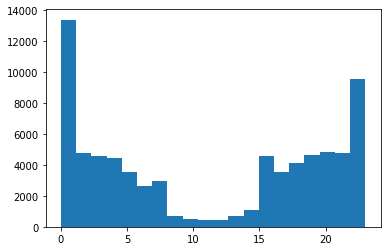

In [38]:
plt.hist(df_ca["hour"], bins=20)
plt.show()

In [39]:
review_count = pd.DataFrame(df_ca["hour"].value_counts())
review_count["hr"] = review_count.index
review_count.reset_index
review_count = review_count.rename(columns={"hour": "num_reviews"}).sort_values(
    by=["hr"]
)
# review_count

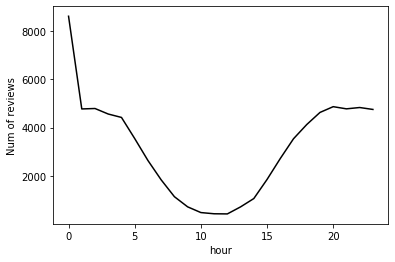

In [40]:
plt.plot((review_count["hr"]), review_count["num_reviews"], color="black")
plt.xlabel("hour")
plt.ylabel("Num of reviews")
# plt.legend()
plt.show()

#### Write to csv df_ca

In [41]:
#df_ca.to_csv("df_ca.csv", index=True)

### Text Analysis

In [42]:
df_ca.isnull().values.any()

False

In [43]:
df_ca["reviewText"].isnull().values.any()

False

In [44]:
import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

In [45]:
# It takes a while
for d in data_ca_:
    t = d['reviewText']
    d['sentences'] = split_into_sentences(t)
    d['sentiments'] = []
    for each in d['sentences']:
        d['sentiments'].append(TextBlob(each).sentiment[0])

In [46]:
#random check
data_ca_[10589]

{'rating': 4.0,
 'reviewerName': 'James Kemp',
 'reviewText': 'It is what it. If you like Hot Wings then you will love the wings here. Its a great place to drink beers and eat wings while watching a game.    If you think you will be bother by the waitresses, then skip it.',
 'categories': ['American Restaurant'],
 'gPlusPlaceId': '109523534701774622111',
 'unixReviewTime': 1328231379,
 'reviewTime': 'Feb 2, 2012',
 'gPlusUserId': '100923767565653432429',
 'gps': [34.072835, -117.880006],
 'price': '$$$',
 'sentences': ['It is what it.',
  'If you like Hot Wings then you will love the wings here.',
  'Its a great place to drink beers and eat wings while watching a game.',
  'If you think you will be bother by the waitresses, then skip it.'],
 'sentiments': [0.0, 0.375, 0.2, 0.0]}

#### Sample TextBlob functionality

In [47]:
TextBlob('It is what it.').sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

#### New feature addition 

In [59]:
dataset = data_ca_
for i in range(0, len(dataset)):
    dataset[i].update({'reviewLength':len(dataset[i]['reviewText'])})
    dataset[i].update({'reviewHour':int(datetime.utcfromtimestamp(dataset[i]['unixReviewTime']).strftime('%Y-%m-%d %H:%M:%S')[11:13])})
    dataset[i].update({'priceRank':1 if dataset[i]['price'] == ['$'] else 2 if dataset[i]['price'] == ['$$'] else 3})
data_ca_ = dataset

In [74]:
data_ca_[20]

{'rating': 5.0,
 'reviewerName': 'Mary Gainza',
 'reviewText': 'Sephora is a great store, i always think of back home and tell myself i wish we had sephora in my country, their staff is always helpful and smiley, their products are wide in range and they always have something nice for just anybody.  I wish their perfume selection was wider but i think the store is very complete in general.',
 'categories': ['Cosmetics Store'],
 'gPlusPlaceId': '114964822538426146633',
 'unixReviewTime': 1355436651,
 'reviewTime': 'Dec 13, 2012',
 'gPlusUserId': '100000715097692381911',
 'gps': [37.784983, -122.407872],
 'price': '$',
 'sentences': ['Sephora is a great store, i always think of back home and tell myself i wish we had sephora in my country, their staff is always helpful and smiley, their products are wide in range and they always have something nice for just anybody.',
  'I wish their perfume selection was wider but i think the store is very complete in general.'],
 'sentiments': [0.325, 

### Data split

In [62]:
# random.shuffle(data_ca_)
tr_len = round(0.8 * len(data_ca_))
va_len = round(0.1 * len(data_ca_))
te_len = round(0.1 * len(data_ca_))

tr_03 = data_ca_[0:tr_len]
va_03 = data_ca_[tr_len : tr_len + va_len]
te_03 = data_ca_[tr_len + va_len :]

len(tr_03), len(va_03), len(te_03)

(61003, 7625, 7626)

In [63]:
def feature(datum):
    feat = []
    feat.append(1)
    if len(datum['sentiments']) != 0:
        count_pos = 0
        count_neg = 0
        for l in datum['sentiments']:
            if l > 0:
                count_pos+=1
            else:
                count_neg+=1
                
        pos_prop = count_pos/len(datum['sentiments'])
        feat.append(pos_prop)
            
        neg_prop = count_neg/len(datum['sentiments'])
        feat.append(neg_prop)
    else:
        feat.append(0)
        feat.append(0)
    #feat.append(datum['reviewLength'])
    #for l in datum['hotHour'] + datum['hotPrice'] + datum['hotSentiment']:
        #feat.append(l)
    return feat

In [64]:
X = [feature(d) for d in tr_03]
y = [d["rating"] for d in tr_03]
len(X), len(y)

(61003, 61003)

In [65]:
X[:5]

[[1, 0, 0],
 [1, 0.6666666666666666, 0.3333333333333333],
 [1, 1.0, 0.0],
 [1, 1.0, 0.0],
 [1, 0.0, 1.0]]

In [66]:
clf = linear_model.Ridge(1.0, fit_intercept=False)  # MSE + 1.0 l2
clf.fit(X, y)
theta = clf.coef_
pred = clf.predict(X)

In [67]:
theta

array([ 3.98272915,  0.53877072, -0.93523282])

### Function MSE and MAE

In [68]:
def MSE(predictions, labels):
    differences = [(x - y) ** 2 for x, y in zip(predictions, labels)]
    return sum(differences) / len(differences)
def MAE(predictions, labels):
    diff = [abs(x-y) for x, y in zip(predictions, labels)]
    return sum(diff)/ len(diff)

In [69]:
pred[:5]

array([3.98272915, 4.03016536, 4.52149987, 4.52149987, 3.04749633])

In [70]:
any(value > 5  for value in pred)

False

In [71]:
X_va_03 = [feature(d) for d in va_03]
y_va_03 = [d["rating"] for d in va_03]

X_te_03 = [feature(d) for d in te_03]
y_te_03 = [d["rating"] for d in te_03]

pred_va_03 = clf.predict(X_va_03)
pred_te_03 = clf.predict(X_te_03)

MSE(pred, y), MSE(pred_va_03, y_va_03), MSE(pred_te_03, y_te_03)

(1.2336416516032958, 1.2308131513767242, 1.2120959814528052)

In [72]:
MAE(pred, y), MAE(pred_va_03, y_va_03), MAE(pred_te_03, y_te_03)

(0.9017521821017932, 0.9025921280371094, 0.888982536001149)

### Model with Sentiment Weights and Price level, Review length, Hour

In [103]:
def feature(datum):
    feat = []
    feat.append(1)
    if len(datum['sentiments']) != 0:
        count_pos = 0
        count_neg = 0
        for l in datum['sentiments']:
            if l > 0:
                count_pos+=1
            else:
                count_neg+=1
                
        pos_prop = count_pos/len(datum['sentiments'])
        feat.append(pos_prop)
            
        neg_prop = count_neg/len(datum['sentiments'])
        feat.append(neg_prop)
    else:
        feat.append(0)
        feat.append(0)
    #feat.append(datum['reviewLength'])
    for l in [np.log(datum['reviewLength']), datum['priceRank'], datum['reviewHour']]:
        feat.append(l)
    return feat

In [104]:
X = [feature(d) for d in tr_03]
y = [d["rating"] for d in tr_03]
len(X), len(y)

(61003, 61003)

In [105]:
X[:5]

[[1, 0, 0, 3.4965075614664802, 3, 0],
 [1, 0.6666666666666666, 0.3333333333333333, 6.731018100482083, 3, 19],
 [1, 1.0, 0.0, 4.23410650459726, 3, 0],
 [1, 1.0, 0.0, 4.30406509320417, 3, 19],
 [1, 0.0, 1.0, 4.653960350157523, 3, 1]]

In [106]:
reviewLength_list = []
for d in data_ca_:
    reviewLength_list.append(d['reviewLength'])    

#### Distribution of reviewLength

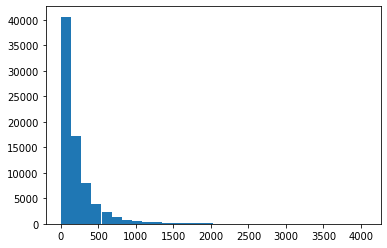

In [107]:
plt.hist((reviewLength_list), bins = 30)
plt.show()

#### Transformed reviewLength

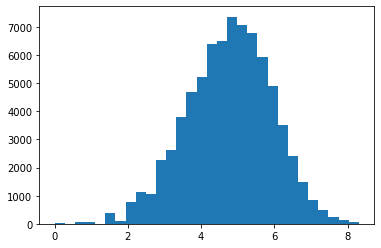

In [108]:
plt.hist(np.log(reviewLength_list), bins = 30)
plt.show()

In [109]:
clf = linear_model.Ridge(1.0, fit_intercept=False)  # MSE + 1.0 l2
clf.fit(X, y)
theta = clf.coef_
pred = clf.predict(X)

In [110]:
theta

array([ 0.45344422,  0.76691042, -0.63213456, -0.17007165,  1.36033267,
        0.00291926])

In [112]:
pred[:5]

array([3.93978542, 3.74571497, 4.58125117, 4.62481919, 3.11372022])

In [113]:
any(value > 5  for value in pred)

True

In [114]:
X_va_03 = [feature(d) for d in va_03]
y_va_03 = [d["rating"] for d in va_03]

X_te_03 = [feature(d) for d in te_03]
y_te_03 = [d["rating"] for d in te_03]

pred_va_03 = clf.predict(X_va_03)
pred_te_03 = clf.predict(X_te_03)

MSE(pred, y), MSE(pred_va_03, y_va_03), MSE(pred_te_03, y_te_03)

(1.2036511116060722, 1.2038350098331325, 1.1831157464451352)

In [115]:
MAE(pred, y), MAE(pred_va_03, y_va_03), MAE(pred_te_03, y_te_03)

(0.8936337514380902, 0.8952406537371121, 0.8816734518854723)

### Ignore below

### Pearson distance calculation

In [111]:
usersPerPlace = defaultdict(set)
placesPerUser = defaultdict(set)
upr = []
for d in tr_03:
    user, place, rating = 'u' + d['gPlusUserId'], 'p' + d['gPlusPlaceId'], d['rating']
    usersPerPlace[place].add((user, rating))
    placesPerUser[user].add((place, rating))
    upr.append([user, place, rating])

# train set users and places
userList = [u for u in placesPerUser] 
placeList = [p for p in usersPerPlace]

In [92]:
len(usersPerPlace['p115827996910815192564'])

4

In [138]:
len(usersPerPlace), len(placesPerUser)

(27252, 29602)

In [118]:
#usersPerPlace

In [86]:
avgRatingUser = defaultdict(float)
for d in placesPerUser:
    for i in placesPerUser[d]:
        sum = 0
        sum += sum + i[1]
    avgRatingUser[d] = sum/len(placesPerUser[d])

In [88]:
#avgRatingUser

In [139]:
upr[:5]

[['u100000032416892623125', 'p106591714648856494903', 4.0],
 ['u100000032416892623125', 'p109420033090810328045', 5.0],
 ['u100000032416892623125', 'p115827996910815192564', 5.0],
 ['u100000106576186066497', 'p108196901293702895067', 5.0],
 ['u100000106576186066497', 'p111971088396054239194', 5.0]]

In [2]:
def p(u):
    common_places = []
    for u1 in userList:
        if u == u1: continue
        p_u_u1 = (placesPerUser[u].intersection(placesPerUser[u1]))
        common_places.append((u, u1, p_u_u1 ))
    return common_places

In [124]:
len(userList)

29602

In [145]:
num_places_rated = [(len(placesPerUser[u]), u) for u in placesPerUser]
#sorted(num_places_rated, reverse=True)

[(187, 'u104476571019985690728'),
 (135, 'u102217125735823374958'),
 (133, 'u100630358511294773071'),
 (128, 'u104897810989125884239'),
 (117, 'u103847313511878826614'),
 (108, 'u100884676252145293797'),
 (104, 'u103946100672656644157'),
 (100, 'u102951244563603960635'),
 (90, 'u103522191271754853617'),
 (88, 'u104316377167510433542'),
 (88, 'u100851929446331696478'),
 (85, 'u101230245043787959581'),
 (84, 'u103735349383231046110'),
 (83, 'u103643162894536968927'),
 (83, 'u101038793101119748720'),
 (79, 'u100433794298719449846'),
 (78, 'u104847770319584345133'),
 (75, 'u102870125420863979110'),
 (75, 'u101258974185036514649'),
 (74, 'u101684759371052236980'),
 (72, 'u100778955555847133098'),
 (71, 'u101672438400341524494'),
 (68, 'u100311654040232848305'),
 (67, 'u102506861739182739700'),
 (66, 'u104051623244958334514'),
 (64, 'u103506077386497475225'),
 (64, 'u103371607510910697387'),
 (63, 'u102667447234394435742'),
 (62, 'u104730969284048173235'),
 (60, 'u103100286417625000956'),
 (

In [148]:
placesPerUser['u104476571019985690728'].intersection(placesPerUser['u104897810989125884239'])

{('p100753276900056518352', 4.0), ('p102155716924328315301', 4.0)}

In [149]:
num_users_rated = [(len(usersPerPlace[p]), p) for p in usersPerPlace]
#sorted(num_users_rated, reverse=True)

[(60, 'p103578313662919495188'),
 (53, 'p115892519691609455114'),
 (51, 'p105960800259063764490'),
 (48, 'p113892928979179719457'),
 (47, 'p116851551368109810342'),
 (47, 'p109360269436587995777'),
 (46, 'p106657922004310165898'),
 (45, 'p110785022279422442473'),
 (44, 'p112896688265570643259'),
 (42, 'p117494580733755207887'),
 (42, 'p112181377194391010841'),
 (41, 'p114848478602803431611'),
 (41, 'p114015360086054639085'),
 (40, 'p109321959683754947833'),
 (37, 'p106971195381578077658'),
 (37, 'p103606313457720659052'),
 (35, 'p107740704895313632419'),
 (34, 'p112458756946472267587'),
 (33, 'p104743172009835954981'),
 (32, 'p115465325301995082003'),
 (32, 'p100130838696633414443'),
 (31, 'p110856227366858987552'),
 (31, 'p102904369529388676354'),
 (30, 'p116028272836626536987'),
 (30, 'p112902108695794413270'),
 (30, 'p111763436659307253849'),
 (30, 'p111413857674877940502'),
 (30, 'p109893500126473933759'),
 (30, 'p109808664452354928350'),
 (30, 'p107984051541957632869'),
 (30, 'p10

In [151]:
#usersPerPlace['p103578313662919495188']

In [ ]:
def pearson_sim(u1, u2):
    users = usersPerPlace[i]
    #print(users)
    
    # gives a a set of all the books a user 'u' read
    for u in users:
        candidatePlaces = candidatePlaces.union(placesPerUser[u])
    
    #print(candidateBooks)
    # i2 is one other book to compare with i
    for i2 in users:
        if i2 == i: continue
        sim = Jaccard(users, usersPerBook[i2])
        #print(sim)
        similarities.append((sim,i2))
        similarities.sort(reverse=True)
    return similarities[0]#, users, candidateBooks
    


In [ ]:
[u.values() for u in usersPerPlace]

In [48]:
data_ca_[:5]

[{'rating': 4.0,
  'reviewerName': 'william spindler',
  'reviewText': 'Best War Wanton soup in Red Bluff',
  'categories': ['Asian Restaurant', 'Chinese Restaurant'],
  'gPlusPlaceId': '106591714648856494903',
  'unixReviewTime': 1394669496,
  'reviewTime': 'Mar 12, 2014',
  'gPlusUserId': '100000032416892623125',
  'gps': [40.179159, -122.236162],
  'price': '$$$'},
 {'rating': 5.0,
  'reviewerName': 'william spindler',
  'reviewText': "This is a review that is long overdo. I've been enjoying the great pizza at this restaurant for over a year now and it's hands down the best in town. I saw a review on here saying the pizza was greasy, and I'll bet it was for a peperoni pizza. I don't know how you could put so many slices of peperoni on, where you can't even see the cheese, without a little pepperoni grease escaping. These guys at Firehouse make the pizzas that everyone else does in their commercials, you can watch as they pile the toppings a mile high on every pie. And when was the l

#### Function - MSE

In [83]:
df_ca_02 = pd.DataFrame.from_dict(data_ca_)
df_ca_02.to_csv('df_ca_02.csv', index=False)